# Import libraries and setup

In [6]:
# Cell 1: Import libraries and setup
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, feature
from skimage.feature import blob_dog
from rich.progress import track
import warnings

warnings.filterwarnings("ignore")
sns.set(color_codes=True, style="white")
print("📦 Libraries imported successfully")

📦 Libraries imported successfully


# Configuration and global parameters

In [7]:
# Cell 2: Configuration and global parameters
# Main data directory
BASE_DIR = "/Users/GGM/Library/CloudStorage/Dropbox/Collaboration_YiZhu/2024Nov-UCP1_IL1b_quantification-GG"
CONDITIONS = ["RT", "Cold", "Cold_Denervation"]

# Image parameters
PIXEL_SIZE_NM = 300  # nm per pixel
CHANNEL_NAMES = ["UCP1", "IL1b"]

# Fixed detection parameters
FIXED_THRESHOLD = 0.15
FIXED_MIN_SIGMA = 2
FIXED_MAX_SIGMA = 5.0

# PCF parameters (large scale analysis)
PCF_MAX_DISTANCE_NM = 12e3
PCF_RING_WIDTH_NM = 500
PCF_STEP_NM = 200

# Create results directories
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "pcf_curves"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "summary_plots"), exist_ok=True)

print("✅ Configuration complete!")
print(
    f"📋 Detection params: threshold={FIXED_THRESHOLD}, σ=({FIXED_MIN_SIGMA}, {FIXED_MAX_SIGMA})"
)
print(
    f"📏 PCF range: 0-{PCF_MAX_DISTANCE_NM/1000:.0f}µm, step={PCF_STEP_NM/1000:.0f}µm"
)

✅ Configuration complete!
📋 Detection params: threshold=0.15, σ=(2, 5.0)
📏 PCF range: 0-12µm, step=0µm


# Core processing functions

In [8]:
# Cell 3: Core processing functions
def load_tif_image(filepath):
    """Load a two-channel TIF image."""
    try:
        image = io.imread(filepath)
        if len(image.shape) == 3 and image.shape[0] == 2:
            return image[0], image[1]  # UCP1, IL1b
        elif len(image.shape) == 3 and image.shape[2] == 2:
            return image[:, :, 0], image[:, :, 1]
        else:
            raise ValueError(f"Expected 2-channel image, got shape {image.shape}")
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None


def detect_puncta(
    image,
    threshold=FIXED_THRESHOLD,
    min_sigma=FIXED_MIN_SIGMA,
    max_sigma=FIXED_MAX_SIGMA,
):
    """Detect puncta using DoG blob detection with fixed parameters."""
    if image is None:
        return np.array([])

    # Normalize image to 0-1 range
    image_norm = (image - image.min()) / (image.max() - image.min())

    # Detect blobs
    blobs = blob_dog(
        image_norm,
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        threshold=threshold,
        overlap=0.5,
    )
    return blobs


def calculate_pcf_no_boundaries(
    x_ref, y_ref, x_interest, y_interest, image_shape, pixel_size_nm
):
    """Calculate PCF without cell boundaries, using entire image as analysis region."""
    # Convert coordinates to nanometers
    x_ref_nm = x_ref * pixel_size_nm
    y_ref_nm = y_ref * pixel_size_nm
    x_interest_nm = x_interest * pixel_size_nm
    y_interest_nm = y_interest * pixel_size_nm

    # Image dimensions in nanometers
    image_area_nm2 = (image_shape[0] * pixel_size_nm) * (image_shape[1] * pixel_size_nm)

    # Particle counts and densities
    N_ref = len(x_ref)
    N_interest = len(x_interest)

    if N_ref == 0 or N_interest == 0:
        return np.array([]), np.array([])

    rho_ref_per_nm2 = N_ref / image_area_nm2
    rho_interest_per_nm2 = N_interest / image_area_nm2

    # Setup distance bins
    bin_starts = np.arange(0, PCF_MAX_DISTANCE_NM - PCF_RING_WIDTH_NM, PCF_STEP_NM)
    bin_ends = bin_starts + PCF_RING_WIDTH_NM
    ring_areas_nm2 = np.pi * (bin_ends**2 - bin_starts**2)

    # Calculate PCF
    lst_hist_per_point_cross = []

    for i in range(len(x_ref_nm)):
        # Calculate distances to all interest points
        distances = np.sqrt(
            (x_ref_nm[i] - x_interest_nm) ** 2 + (y_ref_nm[i] - y_interest_nm) ** 2
        )

        # Create histogram for this reference point
        hist_per_point = np.zeros(len(bin_starts))
        for distance in distances:
            bin_indices = (bin_starts <= distance) & (bin_ends >= distance)
            hist_per_point += bin_indices.astype(int)

        lst_hist_per_point_cross.append(hist_per_point)

    # Calculate normalization factors
    norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2
    norm_factors_cross[norm_factors_cross == 0] = 1  # Avoid division by zero

    PairCorr_cross = np.sum(lst_hist_per_point_cross, axis=0) / norm_factors_cross

    return bin_starts + PCF_RING_WIDTH_NM / 2, PairCorr_cross  # Return bin centers


def get_tif_files(condition_dir):
    """Get all TIF files in a condition directory."""
    if not os.path.exists(condition_dir):
        return []

    tif_files = []
    try:
        for file in os.listdir(condition_dir):
            if file.lower().endswith((".tif", ".tiff")):
                full_path = os.path.join(condition_dir, file)
                if os.path.isfile(full_path):
                    tif_files.append(full_path)
    except PermissionError:
        print(f"❌ Permission denied accessing {condition_dir}")
        return []

    return sorted(tif_files)


print("✅ Core functions ready!")

✅ Core functions ready!


# Batch Processing Functions

In [9]:
# Cell 4: Batch processing pipeline
def process_single_image(filepath, condition):
    """Process a single image: detect puncta and calculate PCF."""
    filename = os.path.basename(filepath)

    # Load image
    ch1_image, ch2_image = load_tif_image(filepath)
    if ch1_image is None or ch2_image is None:
        return None

    # Detect puncta
    ch1_blobs = detect_puncta(ch1_image)
    ch2_blobs = detect_puncta(ch2_image)

    if len(ch1_blobs) == 0 or len(ch2_blobs) == 0:
        print(f"   ⚠️ Skipping {filename} - no puncta in one or both channels")
        return None

    # Calculate PCF
    try:
        ch1_y, ch1_x = ch1_blobs[:, 0], ch1_blobs[:, 1]
        ch2_y, ch2_x = ch2_blobs[:, 0], ch2_blobs[:, 1]

        distances, pcf_values = calculate_pcf_no_boundaries(
            ch1_x, ch1_y, ch2_x, ch2_y, ch1_image.shape, PIXEL_SIZE_NM
        )

        # Save individual PCF curve
        pcf_df = pd.DataFrame({"distance_um": distances / 1000, "pcf": pcf_values})
        pcf_file = os.path.join(
            RESULTS_DIR, "pcf_curves", f"{os.path.splitext(filename)[0]}_pcf.csv"
        )
        pcf_df.to_csv(pcf_file, index=False)

        result = {
            "filename": filename,
            "condition": condition,
            "distances_nm": distances,
            "pcf_values": pcf_values,
            "ch1_count": len(ch1_blobs),
            "ch2_count": len(ch2_blobs),
        }

        print(f"   ✅ {filename}: {len(ch1_blobs)} UCP1, {len(ch2_blobs)} IL1β puncta")
        return result

    except Exception as e:
        print(f"   ❌ PCF calculation failed for {filename}: {e}")
        return None


def process_all_conditions():
    """Process all conditions and return organized results."""
    all_results = {}

    print("🚀 Starting Complete Pipeline Processing")
    print("=" * 60)

    for condition in CONDITIONS:
        condition_dir = os.path.join(BASE_DIR, condition)
        if not os.path.exists(condition_dir):
            print(f"❌ Condition directory not found: {condition_dir}")
            continue

        tif_files = get_tif_files(condition_dir)
        if not tif_files:
            print(f"❌ No TIF files found in {condition_dir}")
            continue

        print(f"\n📁 CONDITION: {condition} ({len(tif_files)} files)")
        print("-" * 40)

        condition_results = []
        for filepath in track(tif_files, description=f"Processing {condition}"):
            result = process_single_image(filepath, condition)
            if result is not None:
                condition_results.append(result)

        all_results[condition] = condition_results

        # Print condition summary
        if condition_results:
            total_ch1 = sum(r["ch1_count"] for r in condition_results)
            total_ch2 = sum(r["ch2_count"] for r in condition_results)
            avg_ch1 = total_ch1 / len(condition_results)
            avg_ch2 = total_ch2 / len(condition_results)
            print(f"📊 {condition} Summary: {len(condition_results)} successful")
            print(f"   UCP1: {total_ch1} total ({avg_ch1:.1f} avg per image)")
            print(f"   IL1β: {total_ch2} total ({avg_ch2:.1f} avg per image)")

    return all_results


print("✅ Batch processing pipeline ready!")

✅ Batch processing pipeline ready!


# Batch Processing for puncta detection

In [10]:
# Cell 5: Execute processing and save results
# Run the complete pipeline
all_results = process_all_conditions()

# Save results
total_processed = sum(len(results) for results in all_results.values())
if total_processed > 0:
    # Save complete results
    results_file = os.path.join(RESULTS_DIR, "all_pcf_results.pkl")
    with open(results_file, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"\n💾 Results saved to: {results_file}")

    print(f"\n🎉 Pipeline Complete!")
    print(f"📈 Total processed: {total_processed} images")
    print(f"📁 Individual PCF curves: {RESULTS_DIR}/pcf_curves/")
    print(f"💾 Complete results: {results_file}")
else:
    print("❌ No images processed successfully")


Output()

✅ RT 20x2_merged_UCP1_green_IL1b_magenta.tif: 1954 UCP1, 623 IL1β puncta

✅ RT 20x3_merged_UCP1_green_IL1b_magenta.tif: 2923 UCP1, 540 IL1β puncta

✅ RT 20x4_merged_UCP1_green_IL1b_magenta.tif: 2515 UCP1, 515 IL1β puncta

✅ RT 20x5_merged_UCP1_green_IL1b_magenta.tif: 4665 UCP1, 741 IL1β puncta

Output()

📊 RT Summary: 4 successful
   UCP1: 12057 total (3014.2 avg per image)
   IL1β: 2419 total (604.8 avg per image)

📁 CONDITION: Cold (8 files)
----------------------------------------


✅ cold 20x1_merged_UCP1_green_IL1b_magenta.tif: 3819 UCP1, 56 IL1β puncta

✅ cold 20x2_merged_UCP1_green_IL1b_magenta.tif: 3776 UCP1, 143 IL1β puncta

✅ cold 20x3_merged_UCP1_green_IL1b_magenta.tif: 3906 UCP1, 137 IL1β puncta

✅ cold 20x4_merged_UCP1_green_IL1b_magenta.tif: 4307 UCP1, 38 IL1β puncta

✅ cold 20x6_merged_UCP1_green_IL1b_magenta.tif: 6562 UCP1, 161 IL1β puncta

✅ cold 20x7_merged_UCP1_green_IL1b_magenta.tif: 7107 UCP1, 30 IL1β puncta

✅ cold 20x8_merged_UCP1_green_IL1b_magenta.tif: 5884 UCP1, 90 IL1β puncta

✅ cold 20x9_merged_UCP1_green_IL1b_magenta.tif: 5964 UCP1, 43 IL1β puncta

Output()

📊 Cold Summary: 8 successful
   UCP1: 41325 total (5165.6 avg per image)
   IL1β: 698 total (87.2 avg per image)

📁 CONDITION: Cold_Denervation (4 files)
----------------------------------------


✅ cold denervation 20x1_merged_UCP1_green_IL1b_magenta.tif: 3561 UCP1, 935 IL1β puncta

✅ cold denervation 20x2_merged_UCP1_green_IL1b_magenta.tif: 4283 UCP1, 653 IL1β puncta

✅ cold denervation 20x3_merged_UCP1_green_IL1b_magenta.tif: 3777 UCP1, 643 IL1β puncta

✅ cold denervation 20x5_merged_UCP1_green_IL1b_magenta.tif: 3656 UCP1, 1133 IL1β puncta

📊 Cold_Denervation Summary: 4 successful
   UCP1: 15277 total (3819.2 avg per image)
   IL1β: 3364 total (841.0 avg per image)

💾 Results saved to: /Users/GGM/Library/CloudStorage/Dropbox/Collaboration_YiZhu/2024Nov-UCP1_IL1b_quantification-GG/results/all_pcf_results.pkl

🎉 Pipeline Complete!
📈 Total processed: 16 images
📁 Individual PCF curves: /Users/GGM/Library/CloudStorage/Dropbox/Collaboration_YiZhu/2024Nov-UCP1_IL1b_quantification-GG/results/pcf_curves/
💾 Complete results: /Users/GGM/Library/CloudStorage/Dropbox/Collaboration_YiZhu/2024Nov-UCP1_IL1b_quantification-GG/results/all_pcf_results.pkl


# Results visualization and analysis

🔄 Applying long-distance normalization and generating SEM plots...
🔄 Normalizing PCF results using long-distance method
📏 Normalization distance threshold: 10µm
📊 Using 10 bins for normalization
📁 Processing RT: 4 images
📁 Processing Cold: 8 images
📁 Processing Cold_Denervation: 4 images

📊 Normalization Summary:
   Mean normalization factor: 1.087 ± 0.145
   Mean baseline CV: 9.5%
   RT: factor=1.088±0.083, CV=7.4%
   Cold: factor=1.081±0.202, CV=12.8%
   Cold_Denervation: factor=1.098±0.054, CV=4.9%


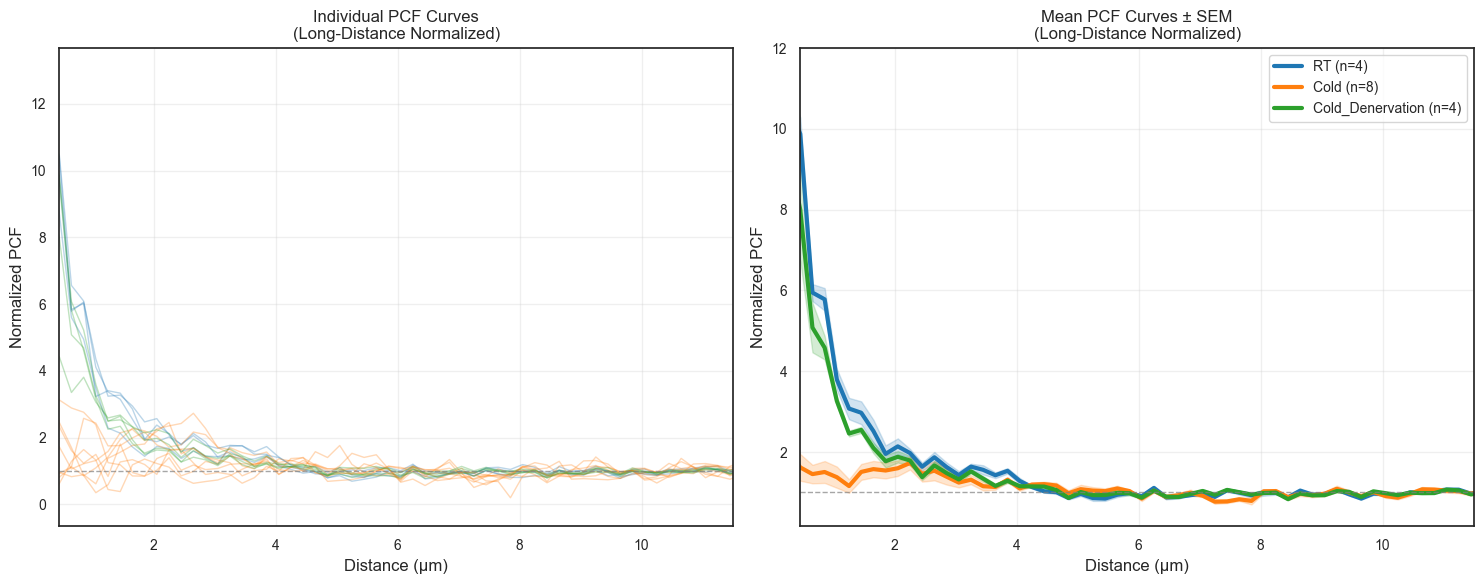

📊 Plot saved: /Users/GGM/Library/CloudStorage/Dropbox/Collaboration_YiZhu/2024Nov-UCP1_IL1b_quantification-GG/results/summary_plots/pcf_comparison_normalized_sem.png
📊 Summary Statistics by Condition (Normalized PCF):
                 ucp1_count                 il1b_count          max_pcf  \
                       mean       std count       mean      std    mean   
condition                                                                 
Cold               5165.625  1359.654     8      87.25   53.006   3.008   
Cold_Denervation   3819.250   321.555     4     841.00  237.099   9.607   
RT                 3014.250  1169.998     4     604.75  101.890  10.850   

                        pcf_at_1um        pcf_at_5um        pcf_at_10um  \
                    std       mean    std       mean    std        mean   
condition                                                                 
Cold              0.996      1.378  0.743      1.082  0.305       0.912   
Cold_Denervation  3.731      3.

In [11]:
# Cell 6: Results visualization and analysis (WITH LONG-DISTANCE NORMALIZATION & SEM)
import scipy.stats as stats
from scipy import stats


def normalize_pcf_long_distance(
    pcf_values,
    n_bins_for_normalization=10,
    bin_centers=None,
    max_correlation_distance_nm=10e3,
):
    """
    Normalize PCF using long-distance bins to correct for systematic bias.
    Based on your manual PCF approach.
    """
    # Ensure we have valid input
    if len(pcf_values) < n_bins_for_normalization:
        raise ValueError(
            f"PCF has {len(pcf_values)} bins, need at least {n_bins_for_normalization}"
        )

    # Method 1: Use last N bins regardless of distance
    normalization_bins = pcf_values[-n_bins_for_normalization:]

    # Method 2: If bin centers provided, only use bins beyond max_correlation_distance
    if bin_centers is not None:
        long_distance_mask = bin_centers > max_correlation_distance_nm
        if np.sum(long_distance_mask) >= n_bins_for_normalization:
            normalization_bins = pcf_values[long_distance_mask]

    # Calculate normalization factor and statistics
    normalization_factor = np.mean(normalization_bins)
    normalization_std = np.std(normalization_bins)
    baseline_coefficient_of_variation = normalization_std / normalization_factor

    # Apply normalization
    normalized_pcf = pcf_values / normalization_factor

    return {
        "normalized_pcf": normalized_pcf,
        "raw_pcf": pcf_values,
        "normalization_factor": normalization_factor,
        "normalization_bins": normalization_bins,
        "normalization_std": normalization_std,
        "baseline_cv": baseline_coefficient_of_variation,
        "n_bins_used": len(normalization_bins),
    }


def apply_long_distance_normalization_to_results(
    all_results, n_bins_for_normalization=10, max_correlation_distance_nm=10e3
):  # 80µm for large scale
    """Apply long-distance normalization to all PCF results."""
    if not all_results:
        return []

    # Calculate bin centers from first result
    first_result = next(iter(all_results.values()))[0]
    bin_centers = first_result["distances_nm"]

    print(f"🔄 Normalizing PCF results using long-distance method")
    print(
        f"📏 Normalization distance threshold: {max_correlation_distance_nm/1000:.0f}µm"
    )
    print(f"📊 Using {n_bins_for_normalization} bins for normalization")
    print("=" * 70)

    normalized_results = {}
    normalization_stats = []

    for condition, results in all_results.items():
        print(f"📁 Processing {condition}: {len(results)} images")
        normalized_results[condition] = []

        for result in results:
            try:
                # Apply normalization
                norm_result = normalize_pcf_long_distance(
                    result["pcf_values"],
                    n_bins_for_normalization=n_bins_for_normalization,
                    bin_centers=bin_centers,
                    max_correlation_distance_nm=max_correlation_distance_nm,
                )

                # Create updated result dictionary
                updated_result = result.copy()
                updated_result.update(
                    {
                        "pcf_normalized": norm_result["normalized_pcf"],
                        "pcf_raw": norm_result["raw_pcf"],
                        "normalization_factor": norm_result["normalization_factor"],
                        "normalization_std": norm_result["normalization_std"],
                        "baseline_cv": norm_result["baseline_cv"],
                        "n_normalization_bins": norm_result["n_bins_used"],
                    }
                )

                normalized_results[condition].append(updated_result)

                # Collect stats
                normalization_stats.append(
                    {
                        "condition": condition,
                        "filename": result["filename"],
                        "normalization_factor": norm_result["normalization_factor"],
                        "baseline_cv": norm_result["baseline_cv"],
                    }
                )

            except Exception as e:
                print(f"   ❌ Error normalizing {result['filename']}: {e}")
                continue

    # Print normalization summary
    if normalization_stats:
        stats_df = pd.DataFrame(normalization_stats)
        print(f"\n📊 Normalization Summary:")
        print(
            f"   Mean normalization factor: {stats_df['normalization_factor'].mean():.3f} ± {stats_df['normalization_factor'].std():.3f}"
        )
        print(f"   Mean baseline CV: {stats_df['baseline_cv'].mean():.1%}")

        # Per-condition stats
        for condition in CONDITIONS:
            cond_stats = stats_df[stats_df["condition"] == condition]
            if len(cond_stats) > 0:
                print(
                    f"   {condition}: factor={cond_stats['normalization_factor'].mean():.3f}±{cond_stats['normalization_factor'].std():.3f}, CV={cond_stats['baseline_cv'].mean():.1%}"
                )

    return normalized_results


def plot_pcf_results_with_sem(all_results, save_path=None):
    """Plot PCF results with SEM error bars, mimicking your manual approach."""
    if not any(all_results.values()):
        print("No results to plot")
        return

    # Use normalized PCF data
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    colors = {"RT": "#1f77b4", "Cold": "#ff7f0e", "Cold_Denervation": "#2ca02c"}

    # Get distance array (convert to microns)
    first_result = next(iter(all_results.values()))[0]
    distances_um = first_result["distances_nm"] / 1000

    # Individual curves (left panel)
    for condition, results in all_results.items():
        if not results:
            continue
        color = colors.get(condition, "gray")
        for result in results:
            # Use normalized PCF
            pcf_data = result.get("pcf_normalized", result["pcf_values"])
            axes[0].plot(distances_um, pcf_data, color=color, alpha=0.3, linewidth=1)

    # Mean curves with SEM (right panel)
    for condition, results in all_results.items():
        if not results:
            continue

        # Collect all PCF curves for this condition
        pcf_matrix = []
        for result in results:
            pcf_data = result.get("pcf_normalized", result["pcf_values"])
            pcf_matrix.append(pcf_data)

        if not pcf_matrix:
            continue

        pcf_matrix = np.array(pcf_matrix)

        # Calculate mean and SEM
        mean_pcf = np.mean(pcf_matrix, axis=0)
        sem_pcf = stats.sem(pcf_matrix, axis=0)  # Standard Error of Mean

        color = colors.get(condition, "gray")
        n_samples = len(results)

        # Plot mean line
        axes[1].plot(
            distances_um,
            mean_pcf,
            color=color,
            linewidth=3,
            label=f"{condition} (n={n_samples})",
        )

        # Plot SEM as shaded area
        axes[1].fill_between(
            distances_um, mean_pcf - sem_pcf, mean_pcf + sem_pcf, alpha=0.2, color=color
        )

    # Format plots
    for ax in axes:
        ax.axhline(1, ls="--", c="gray", lw=1, alpha=0.7)
        ax.set_xlabel("Distance (μm)", fontsize=12)
        ax.set_ylabel("Normalized PCF", fontsize=12)
        ax.set_xlim(
            (PCF_RING_WIDTH_NM / 2 + PCF_STEP_NM) / 1000,
            (PCF_MAX_DISTANCE_NM - PCF_RING_WIDTH_NM) / 1000,
        )
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)

    axes[0].set_title("Individual PCF Curves\n(Long-Distance Normalized)", fontsize=12)
    axes[1].set_title("Mean PCF Curves ± SEM\n(Long-Distance Normalized)", fontsize=12)
    axes[1].legend(fontsize=10)

    plt.tight_layout()

    # Save plot
    if save_path is None:
        save_path = os.path.join(
            RESULTS_DIR, "summary_plots", "pcf_comparison_normalized_sem.png"
        )

    plt.savefig(save_path, dpi=600, bbox_inches="tight", facecolor="white")
    plt.show()

    print(f"📊 Plot saved: {save_path}")


def generate_summary_table_normalized(all_results):
    """Generate summary statistics table for normalized PCF data."""
    summary_data = []

    for condition, results in all_results.items():
        for result in results:
            # Use normalized PCF data
            pcf_values = result.get("pcf_normalized", result["pcf_values"])
            distances_nm = result["distances_nm"]

            summary_data.append(
                {
                    "condition": condition,
                    "filename": result["filename"],
                    "ucp1_count": result["ch1_count"],
                    "il1b_count": result["ch2_count"],
                    "max_pcf": np.max(pcf_values),
                    "pcf_at_1um": pcf_values[np.argmin(np.abs(distances_nm - 1e3))],
                    "pcf_at_5um": pcf_values[np.argmin(np.abs(distances_nm - 5e3))],
                    "pcf_at_10um": pcf_values[np.argmin(np.abs(distances_nm - 10e3))],
                    "normalization_factor": result.get("normalization_factor", 1.0),
                    "baseline_cv": result.get("baseline_cv", 0.0),
                }
            )

    summary_df = pd.DataFrame(summary_data)
    summary_file = os.path.join(RESULTS_DIR, "pcf_summary_normalized.csv")
    summary_df.to_csv(summary_file, index=False)

    # Display grouped statistics
    print("📊 Summary Statistics by Condition (Normalized PCF):")
    print("=" * 80)
    grouped = (
        summary_df.groupby("condition")
        .agg(
            {
                "ucp1_count": ["mean", "std", "count"],
                "il1b_count": ["mean", "std"],
                "max_pcf": ["mean", "std"],
                "pcf_at_1um": ["mean", "std"],
                "pcf_at_5um": ["mean", "std"],
                "pcf_at_10um": ["mean", "std"],
                "normalization_factor": ["mean", "std"],
                "baseline_cv": ["mean", "std"],
            }
        )
        .round(3)
    )
    print(grouped)

    print(f"\n💾 Summary table saved: {summary_file}")
    return summary_df


# Execute analysis with normalization
if "all_results" in locals() and any(all_results.values()):
    print("🔄 Applying long-distance normalization and generating SEM plots...")

    # Apply long-distance normalization
    normalized_results = apply_long_distance_normalization_to_results(
        all_results,
        n_bins_for_normalization=10,
        max_correlation_distance_nm=10e3,
    )

    # Generate plots with SEM
    plot_pcf_results_with_sem(normalized_results)

    # Generate summary statistics
    summary_df = generate_summary_table_normalized(normalized_results)

    print(f"\n✅ Analysis complete with long-distance normalization!")
    print(f"📊 Used bins beyond 10e3 nm for normalization")
    print(f"📈 SEM error bars show standard error of the mean")
    print(f"📁 All results saved in {RESULTS_DIR}/")

else:
    print("❌ No results available for analysis. Run processing first.")